In [69]:
import matplotlib as mpl
from numpy import *
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
# 设置GPU内存按需分配
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [71]:
import os
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
 
#原版 config = tf.ConfigProto(allow_soft_placement=True)
config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
#原版 sess = tf.Session(config=config)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.5)
 
config.gpu_options.allow_growth = True
 
sess =tf.compat.v1.Session(config=config)  #注意 ，这里为tensorflow2.0版本，与第1.0有差距。

In [72]:
def pep1(path):
    seqs = open(path).readlines()
    cut = 0
    X = [[AA.index(res.upper()) if res.upper() in AA else 0
          for res in (seq.split()[1][cut:-cut] if cut != 0 else seq.split()[1])]
         for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']

    return np.array(X), np.array(y)

In [73]:
AA = 'XARNDCQEGHILKMFPSTWYV'

In [74]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [75]:
batch_size=256

In [76]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = pep1('train.txt')
x_test,y_test = pep1('test.txt')

In [77]:
classes = sorted(list(set(y_train)))

In [78]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [79]:
prediction_result_cv = []
prediction_result_ind = []

In [80]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE')
out = os.getcwd() + '\\'

In [81]:
input_len = len(x_train[0])

In [98]:
def build_network():
    # 先创建包含多网络层的列表
    conv_layers = [
        layers.Embedding(21, 5, input_length=input_len),
        layers.Conv1D(filters=128, kernel_size=1, padding='same', activation=tf.nn.relu),
        layers.Dropout(0.6),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        layers.Dropout(0.7),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=128, kernel_size=9, padding='same', activation=tf.nn.relu),
        layers.MaxPooling1D(2),
        layers.Dropout(0.7)
    ]

    fc_layers = [
        layers.Dense(64, activation=tf.nn.relu),  # 全连接层， 64 个节点
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation=tf.nn.sigmoid)  # 全连接层， 1 个节点
    ]

    conv_layers.extend(fc_layers)
    network = Sequential(conv_layers)
    network.build(input_shape=[None, 41, 21])
    base_learning_rate = 0.0007
    #network.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    network.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    network.summary()
    return network

In [129]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    network = build_network()
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = network.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = network.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = network.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 41, 5)             105       
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 41, 128)           768       
_________________________________________________________________
dropout_150 (Dropout)        (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d_150 (MaxPoolin (None, 20, 128)           0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 20, 128)           49280     
_________________________________________________________________
dropout_151 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_151 (MaxPoolin (None, 10, 128)         


Epoch 00031: val_loss did not improve from 0.64379
Epoch 32/300
8/8 - 0s - loss: 0.6373 - accuracy: 0.6436 - val_loss: 0.6509 - val_accuracy: 0.6311

Epoch 00032: val_loss did not improve from 0.64379
Epoch 33/300
8/8 - 0s - loss: 0.6423 - accuracy: 0.6342 - val_loss: 0.6472 - val_accuracy: 0.6533

Epoch 00033: val_loss did not improve from 0.64379
Epoch 34/300
8/8 - 0s - loss: 0.6369 - accuracy: 0.6431 - val_loss: 0.6512 - val_accuracy: 0.6311

Epoch 00034: val_loss did not improve from 0.64379
Epoch 35/300
8/8 - 0s - loss: 0.6377 - accuracy: 0.6391 - val_loss: 0.6455 - val_accuracy: 0.6622

Epoch 00035: val_loss did not improve from 0.64379
Epoch 36/300
8/8 - 0s - loss: 0.6385 - accuracy: 0.6327 - val_loss: 0.6448 - val_accuracy: 0.6444

Epoch 00036: val_loss did not improve from 0.64379
Epoch 37/300
8/8 - 0s - loss: 0.6431 - accuracy: 0.6362 - val_loss: 0.6447 - val_accuracy: 0.6667

Epoch 00037: val_loss did not improve from 0.64379
Epoch 38/300
8/8 - 0s - loss: 0.6322 - accuracy:


Epoch 00083: val_loss did not improve from 0.63710
Epoch 84/300
8/8 - 0s - loss: 0.6145 - accuracy: 0.6614 - val_loss: 0.6555 - val_accuracy: 0.6444

Epoch 00084: val_loss did not improve from 0.63710
Epoch 85/300
8/8 - 0s - loss: 0.6126 - accuracy: 0.6634 - val_loss: 0.6456 - val_accuracy: 0.6756

Epoch 00085: val_loss did not improve from 0.63710
Epoch 86/300
8/8 - 0s - loss: 0.5991 - accuracy: 0.6831 - val_loss: 0.6412 - val_accuracy: 0.6756

Epoch 00086: val_loss did not improve from 0.63710
Epoch 87/300
8/8 - 0s - loss: 0.6024 - accuracy: 0.6802 - val_loss: 0.6484 - val_accuracy: 0.6578

Epoch 00087: val_loss did not improve from 0.63710
Epoch 88/300
8/8 - 0s - loss: 0.5996 - accuracy: 0.6802 - val_loss: 0.6451 - val_accuracy: 0.6889

Epoch 00088: val_loss did not improve from 0.63710
Epoch 89/300
8/8 - 0s - loss: 0.5997 - accuracy: 0.6817 - val_loss: 0.6450 - val_accuracy: 0.6578

Epoch 00089: val_loss did not improve from 0.63710
Epoch 90/300
8/8 - 0s - loss: 0.5984 - accuracy:


Epoch 00133: val_loss did not improve from 0.61245
Epoch 134/300
8/8 - 0s - loss: 0.5388 - accuracy: 0.7227 - val_loss: 0.6253 - val_accuracy: 0.6844

Epoch 00134: val_loss did not improve from 0.61245
Epoch 135/300
8/8 - 0s - loss: 0.5366 - accuracy: 0.7276 - val_loss: 0.6196 - val_accuracy: 0.6933

Epoch 00135: val_loss did not improve from 0.61245
Epoch 136/300
8/8 - 0s - loss: 0.5356 - accuracy: 0.7286 - val_loss: 0.6197 - val_accuracy: 0.6978

Epoch 00136: val_loss did not improve from 0.61245
Epoch 137/300
8/8 - 0s - loss: 0.5391 - accuracy: 0.7158 - val_loss: 0.6212 - val_accuracy: 0.6889

Epoch 00137: val_loss did not improve from 0.61245
Epoch 138/300
8/8 - 0s - loss: 0.5379 - accuracy: 0.7217 - val_loss: 0.6173 - val_accuracy: 0.6844

Epoch 00138: val_loss did not improve from 0.61245
Epoch 139/300
8/8 - 0s - loss: 0.5302 - accuracy: 0.7197 - val_loss: 0.6171 - val_accuracy: 0.6756

Epoch 00139: val_loss did not improve from 0.61245
Epoch 140/300
8/8 - 0s - loss: 0.5423 - ac

8/8 - 0s - loss: 0.4907 - accuracy: 0.7494 - val_loss: 0.6123 - val_accuracy: 0.6800

Epoch 00186: val_loss did not improve from 0.60235
Epoch 187/300
8/8 - 0s - loss: 0.4849 - accuracy: 0.7677 - val_loss: 0.6162 - val_accuracy: 0.6933

Epoch 00187: val_loss did not improve from 0.60235
Epoch 188/300
8/8 - 0s - loss: 0.4914 - accuracy: 0.7533 - val_loss: 0.6089 - val_accuracy: 0.6933

Epoch 00188: val_loss did not improve from 0.60235
Epoch 189/300
8/8 - 0s - loss: 0.5045 - accuracy: 0.7454 - val_loss: 0.6126 - val_accuracy: 0.6756

Epoch 00189: val_loss did not improve from 0.60235
Epoch 190/300
8/8 - 0s - loss: 0.4826 - accuracy: 0.7657 - val_loss: 0.6131 - val_accuracy: 0.6889

Epoch 00190: val_loss did not improve from 0.60235
Epoch 191/300
8/8 - 0s - loss: 0.4962 - accuracy: 0.7489 - val_loss: 0.6103 - val_accuracy: 0.6667

Epoch 00191: val_loss did not improve from 0.60235
Epoch 192/300
8/8 - 0s - loss: 0.4831 - accuracy: 0.7632 - val_loss: 0.6149 - val_accuracy: 0.6622

Epoch 00

8/8 - 1s - loss: 0.6943 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.4978

Epoch 00001: val_loss improved from inf to 0.69308, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.6928 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.5022

Epoch 00002: val_loss did not improve from 0.69308
Epoch 3/300
8/8 - 0s - loss: 0.6929 - accuracy: 0.5052 - val_loss: 0.6929 - val_accuracy: 0.5022

Epoch 00003: val_loss improved from 0.69308 to 0.69285, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_1.h5
Epoch 4/300
8/8 - 0s - loss: 0.6921 - accuracy: 0.5240 - val_loss: 0.6920 - val_accuracy: 0.5333

Epoch 00004: val_loss improved from 0.69285 to 0.69202, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_1.h5
Epoch 5/300
8/8 - 0s - loss: 0.6911 - accuracy: 0.5131 - val_loss: 0.6898 - val_accuracy: 0.5911

Epoc


Epoch 00045: val_loss did not improve from 0.61887
Epoch 46/300
8/8 - 0s - loss: 0.6325 - accuracy: 0.6560 - val_loss: 0.6220 - val_accuracy: 0.6800

Epoch 00046: val_loss did not improve from 0.61887
Epoch 47/300
8/8 - 0s - loss: 0.6363 - accuracy: 0.6293 - val_loss: 0.6200 - val_accuracy: 0.6800

Epoch 00047: val_loss did not improve from 0.61887
Epoch 48/300
8/8 - 0s - loss: 0.6324 - accuracy: 0.6436 - val_loss: 0.6214 - val_accuracy: 0.6889

Epoch 00048: val_loss did not improve from 0.61887
Epoch 49/300
8/8 - 0s - loss: 0.6279 - accuracy: 0.6490 - val_loss: 0.6213 - val_accuracy: 0.6933

Epoch 00049: val_loss did not improve from 0.61887
Epoch 50/300
8/8 - 0s - loss: 0.6306 - accuracy: 0.6466 - val_loss: 0.6207 - val_accuracy: 0.6622

Epoch 00050: val_loss did not improve from 0.61887
Epoch 51/300
8/8 - 0s - loss: 0.6373 - accuracy: 0.6312 - val_loss: 0.6234 - val_accuracy: 0.6978

Epoch 00051: val_loss did not improve from 0.61887
Epoch 52/300
8/8 - 0s - loss: 0.6368 - accuracy:


Epoch 00092: val_loss did not improve from 0.59082
Epoch 93/300
8/8 - 0s - loss: 0.5828 - accuracy: 0.6876 - val_loss: 0.5926 - val_accuracy: 0.6978

Epoch 00093: val_loss did not improve from 0.59082
Epoch 94/300
8/8 - 0s - loss: 0.5860 - accuracy: 0.6876 - val_loss: 0.5988 - val_accuracy: 0.6844

Epoch 00094: val_loss did not improve from 0.59082
Epoch 95/300
8/8 - 0s - loss: 0.5971 - accuracy: 0.6812 - val_loss: 0.6041 - val_accuracy: 0.7022

Epoch 00095: val_loss did not improve from 0.59082
Epoch 96/300
8/8 - 0s - loss: 0.5880 - accuracy: 0.6891 - val_loss: 0.6007 - val_accuracy: 0.6889

Epoch 00096: val_loss did not improve from 0.59082
Epoch 97/300
8/8 - 0s - loss: 0.5839 - accuracy: 0.6891 - val_loss: 0.5959 - val_accuracy: 0.6800

Epoch 00097: val_loss did not improve from 0.59082
Epoch 98/300
8/8 - 0s - loss: 0.5852 - accuracy: 0.6836 - val_loss: 0.6017 - val_accuracy: 0.6756

Epoch 00098: val_loss did not improve from 0.59082
Epoch 99/300
8/8 - 0s - loss: 0.5731 - accuracy:

8/8 - 1s - loss: 0.6938 - accuracy: 0.4686 - val_loss: 0.6932 - val_accuracy: 0.4978

Epoch 00001: val_loss improved from inf to 0.69318, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 2/300
8/8 - 0s - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.4978

Epoch 00002: val_loss improved from 0.69318 to 0.69314, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 3/300
8/8 - 0s - loss: 0.6933 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.5022

Epoch 00003: val_loss improved from 0.69314 to 0.69311, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 4/300
8/8 - 0s - loss: 0.6930 - accuracy: 0.5057 - val_loss: 0.6931 - val_accuracy: 0.5067

Epoch 00004: val_loss improved from 0.69311 to 0.69311, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2

8/8 - 0s - loss: 0.6269 - accuracy: 0.6574 - val_loss: 0.6394 - val_accuracy: 0.6400

Epoch 00044: val_loss improved from 0.64382 to 0.63935, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 45/300
8/8 - 0s - loss: 0.6276 - accuracy: 0.6466 - val_loss: 0.6459 - val_accuracy: 0.6400

Epoch 00045: val_loss did not improve from 0.63935
Epoch 46/300
8/8 - 0s - loss: 0.6275 - accuracy: 0.6560 - val_loss: 0.6528 - val_accuracy: 0.6089

Epoch 00046: val_loss did not improve from 0.63935
Epoch 47/300
8/8 - 0s - loss: 0.6298 - accuracy: 0.6426 - val_loss: 0.6414 - val_accuracy: 0.6444

Epoch 00047: val_loss did not improve from 0.63935
Epoch 48/300
8/8 - 0s - loss: 0.6222 - accuracy: 0.6540 - val_loss: 0.6455 - val_accuracy: 0.6400

Epoch 00048: val_loss did not improve from 0.63935
Epoch 49/300
8/8 - 0s - loss: 0.6239 - accuracy: 0.6555 - val_loss: 0.6500 - val_accuracy: 0.6222

Epoch 00049: val_loss did not improve from 0.63935
Epoch 5


Epoch 00090: val_loss improved from 0.61576 to 0.61200, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 91/300
8/8 - 0s - loss: 0.5765 - accuracy: 0.6871 - val_loss: 0.6152 - val_accuracy: 0.6978

Epoch 00091: val_loss did not improve from 0.61200
Epoch 92/300
8/8 - 0s - loss: 0.5678 - accuracy: 0.7009 - val_loss: 0.6098 - val_accuracy: 0.7022

Epoch 00092: val_loss improved from 0.61200 to 0.60985, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 93/300
8/8 - 0s - loss: 0.5716 - accuracy: 0.7029 - val_loss: 0.6105 - val_accuracy: 0.6756

Epoch 00093: val_loss did not improve from 0.60985
Epoch 94/300
8/8 - 0s - loss: 0.5703 - accuracy: 0.6955 - val_loss: 0.6124 - val_accuracy: 0.6622

Epoch 00094: val_loss did not improve from 0.60985
Epoch 95/300
8/8 - 0s - loss: 0.5757 - accuracy: 0.6940 - val_loss: 0.6181 - val_accuracy: 0.6800

Epoch 00095: val_loss did not improve


Epoch 00137: val_loss did not improve from 0.58367
Epoch 138/300
8/8 - 0s - loss: 0.5316 - accuracy: 0.7133 - val_loss: 0.5859 - val_accuracy: 0.7378

Epoch 00138: val_loss did not improve from 0.58367
Epoch 139/300
8/8 - 0s - loss: 0.5085 - accuracy: 0.7385 - val_loss: 0.5821 - val_accuracy: 0.7467

Epoch 00139: val_loss improved from 0.58367 to 0.58213, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 140/300
8/8 - 0s - loss: 0.5128 - accuracy: 0.7405 - val_loss: 0.5781 - val_accuracy: 0.7556

Epoch 00140: val_loss improved from 0.58213 to 0.57812, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_2.h5
Epoch 141/300
8/8 - 0s - loss: 0.5241 - accuracy: 0.7331 - val_loss: 0.5838 - val_accuracy: 0.7200

Epoch 00141: val_loss did not improve from 0.57812
Epoch 142/300
8/8 - 0s - loss: 0.5204 - accuracy: 0.7316 - val_loss: 0.5816 - val_accuracy: 0.7333

Epoch 00142: val_loss did not im

8/8 - 0s - loss: 0.4797 - accuracy: 0.7608 - val_loss: 0.5749 - val_accuracy: 0.7200

Epoch 00187: val_loss did not improve from 0.56969
Epoch 188/300
8/8 - 0s - loss: 0.4812 - accuracy: 0.7627 - val_loss: 0.5785 - val_accuracy: 0.7244

Epoch 00188: val_loss did not improve from 0.56969
Epoch 189/300
8/8 - 0s - loss: 0.4837 - accuracy: 0.7509 - val_loss: 0.5807 - val_accuracy: 0.7289

Epoch 00189: val_loss did not improve from 0.56969
Epoch 190/300
8/8 - 0s - loss: 0.4750 - accuracy: 0.7652 - val_loss: 0.5783 - val_accuracy: 0.7244

Epoch 00190: val_loss did not improve from 0.56969
Epoch 191/300
8/8 - 0s - loss: 0.4861 - accuracy: 0.7687 - val_loss: 0.5773 - val_accuracy: 0.7111

Epoch 00191: val_loss did not improve from 0.56969
Epoch 192/300
8/8 - 0s - loss: 0.4829 - accuracy: 0.7622 - val_loss: 0.5820 - val_accuracy: 0.7200

Epoch 00192: val_loss did not improve from 0.56969
Epoch 193/300
8/8 - 0s - loss: 0.4790 - accuracy: 0.7687 - val_loss: 0.5761 - val_accuracy: 0.7111

Epoch 00


Epoch 00239: val_loss did not improve from 0.56518
Epoch 240/300
8/8 - 0s - loss: 0.4360 - accuracy: 0.7860 - val_loss: 0.5766 - val_accuracy: 0.7378

Epoch 00240: val_loss did not improve from 0.56518
Epoch 241/300
8/8 - 0s - loss: 0.4422 - accuracy: 0.7860 - val_loss: 0.5766 - val_accuracy: 0.7289

Epoch 00241: val_loss did not improve from 0.56518
Epoch 242/300
8/8 - 0s - loss: 0.4430 - accuracy: 0.7909 - val_loss: 0.5766 - val_accuracy: 0.7244

Epoch 00242: val_loss did not improve from 0.56518
Epoch 243/300
8/8 - 0s - loss: 0.4273 - accuracy: 0.7973 - val_loss: 0.5796 - val_accuracy: 0.7244

Epoch 00243: val_loss did not improve from 0.56518
Epoch 244/300
8/8 - 0s - loss: 0.4472 - accuracy: 0.7840 - val_loss: 0.5773 - val_accuracy: 0.7200

Epoch 00244: val_loss did not improve from 0.56518
Epoch 245/300
8/8 - 0s - loss: 0.4440 - accuracy: 0.7835 - val_loss: 0.5770 - val_accuracy: 0.7244

Epoch 00245: val_loss did not improve from 0.56518
Epoch 246/300
8/8 - 0s - loss: 0.4256 - ac


Epoch 00293: val_loss did not improve from 0.56151
Epoch 294/300
8/8 - 0s - loss: 0.4158 - accuracy: 0.8082 - val_loss: 0.5821 - val_accuracy: 0.7111

Epoch 00294: val_loss did not improve from 0.56151
Epoch 295/300
8/8 - 0s - loss: 0.4276 - accuracy: 0.7968 - val_loss: 0.5793 - val_accuracy: 0.7022

Epoch 00295: val_loss did not improve from 0.56151
Epoch 296/300
8/8 - 0s - loss: 0.3981 - accuracy: 0.8102 - val_loss: 0.5863 - val_accuracy: 0.7200

Epoch 00296: val_loss did not improve from 0.56151
Epoch 297/300
8/8 - 0s - loss: 0.4073 - accuracy: 0.8097 - val_loss: 0.5804 - val_accuracy: 0.7022

Epoch 00297: val_loss did not improve from 0.56151
Epoch 298/300
8/8 - 0s - loss: 0.3852 - accuracy: 0.8304 - val_loss: 0.5811 - val_accuracy: 0.7200

Epoch 00298: val_loss did not improve from 0.56151
Epoch 299/300
8/8 - 0s - loss: 0.4209 - accuracy: 0.8043 - val_loss: 0.5796 - val_accuracy: 0.7200

Epoch 00299: val_loss did not improve from 0.56151
Epoch 300/300
8/8 - 0s - loss: 0.3955 - ac

8/8 - 0s - loss: 0.6399 - accuracy: 0.6441 - val_loss: 0.6579 - val_accuracy: 0.6133

Epoch 00021: val_loss did not improve from 0.65571
Epoch 22/300
8/8 - 0s - loss: 0.6383 - accuracy: 0.6406 - val_loss: 0.6564 - val_accuracy: 0.6178

Epoch 00022: val_loss did not improve from 0.65571
Epoch 23/300
8/8 - 0s - loss: 0.6369 - accuracy: 0.6421 - val_loss: 0.6565 - val_accuracy: 0.6267

Epoch 00023: val_loss did not improve from 0.65571
Epoch 24/300
8/8 - 0s - loss: 0.6474 - accuracy: 0.6288 - val_loss: 0.6628 - val_accuracy: 0.5956

Epoch 00024: val_loss did not improve from 0.65571
Epoch 25/300
8/8 - 0s - loss: 0.6513 - accuracy: 0.6258 - val_loss: 0.6619 - val_accuracy: 0.6044

Epoch 00025: val_loss did not improve from 0.65571
Epoch 26/300
8/8 - 0s - loss: 0.6411 - accuracy: 0.6416 - val_loss: 0.6590 - val_accuracy: 0.6089

Epoch 00026: val_loss did not improve from 0.65571
Epoch 27/300
8/8 - 0s - loss: 0.6368 - accuracy: 0.6357 - val_loss: 0.6555 - val_accuracy: 0.6044

Epoch 00027: v


Epoch 00071: val_loss did not improve from 0.65338
Epoch 72/300
8/8 - 0s - loss: 0.6278 - accuracy: 0.6550 - val_loss: 0.6570 - val_accuracy: 0.6178

Epoch 00072: val_loss did not improve from 0.65338
Epoch 73/300
8/8 - 0s - loss: 0.6262 - accuracy: 0.6624 - val_loss: 0.6548 - val_accuracy: 0.6267

Epoch 00073: val_loss did not improve from 0.65338
Epoch 74/300
8/8 - 0s - loss: 0.6266 - accuracy: 0.6579 - val_loss: 0.6542 - val_accuracy: 0.6222

Epoch 00074: val_loss did not improve from 0.65338
Epoch 75/300
8/8 - 0s - loss: 0.6226 - accuracy: 0.6644 - val_loss: 0.6527 - val_accuracy: 0.6311

Epoch 00075: val_loss improved from 0.65338 to 0.65274, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_3.h5
Epoch 76/300
8/8 - 0s - loss: 0.6184 - accuracy: 0.6693 - val_loss: 0.6513 - val_accuracy: 0.6311

Epoch 00076: val_loss improved from 0.65274 to 0.65133, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL


Epoch 00115: val_loss did not improve from 0.63613
Epoch 116/300
8/8 - 0s - loss: 0.5706 - accuracy: 0.7029 - val_loss: 0.6425 - val_accuracy: 0.6044

Epoch 00116: val_loss did not improve from 0.63613
Epoch 117/300
8/8 - 0s - loss: 0.5752 - accuracy: 0.6985 - val_loss: 0.6373 - val_accuracy: 0.6267

Epoch 00117: val_loss did not improve from 0.63613
Epoch 118/300
8/8 - 0s - loss: 0.5647 - accuracy: 0.7034 - val_loss: 0.6378 - val_accuracy: 0.6311

Epoch 00118: val_loss did not improve from 0.63613
Epoch 119/300
8/8 - 0s - loss: 0.5667 - accuracy: 0.7004 - val_loss: 0.6351 - val_accuracy: 0.6356

Epoch 00119: val_loss improved from 0.63613 to 0.63512, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_3.h5
Epoch 120/300
8/8 - 0s - loss: 0.5731 - accuracy: 0.6990 - val_loss: 0.6355 - val_accuracy: 0.6178

Epoch 00120: val_loss did not improve from 0.63512
Epoch 121/300
8/8 - 0s - loss: 0.5644 - accuracy: 0.7069 - val_loss: 0.6362 - val_accur


Epoch 00163: val_loss improved from 0.61785 to 0.61737, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_3.h5
Epoch 164/300
8/8 - 0s - loss: 0.5306 - accuracy: 0.7336 - val_loss: 0.6149 - val_accuracy: 0.6311

Epoch 00164: val_loss improved from 0.61737 to 0.61491, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_3.h5
Epoch 165/300
8/8 - 0s - loss: 0.5260 - accuracy: 0.7316 - val_loss: 0.6230 - val_accuracy: 0.6444

Epoch 00165: val_loss did not improve from 0.61491
Epoch 166/300
8/8 - 0s - loss: 0.5269 - accuracy: 0.7390 - val_loss: 0.6126 - val_accuracy: 0.6356

Epoch 00166: val_loss improved from 0.61491 to 0.61264, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_3.h5
Epoch 167/300
8/8 - 0s - loss: 0.5311 - accuracy: 0.7276 - val_loss: 0.6129 - val_accuracy: 0.6311

Epoch 00167: val_loss did not improve from 0.61264
Epoch 168/300
8/8 - 0s - l


Epoch 00214: val_loss did not improve from 0.61028
Epoch 215/300
8/8 - 0s - loss: 0.5077 - accuracy: 0.7464 - val_loss: 0.6143 - val_accuracy: 0.6533

Epoch 00215: val_loss did not improve from 0.61028
Epoch 216/300
8/8 - 0s - loss: 0.4851 - accuracy: 0.7627 - val_loss: 0.6095 - val_accuracy: 0.6489

Epoch 00216: val_loss improved from 0.61028 to 0.60949, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_3.h5
Epoch 217/300
8/8 - 0s - loss: 0.4821 - accuracy: 0.7622 - val_loss: 0.6175 - val_accuracy: 0.6444

Epoch 00217: val_loss did not improve from 0.60949
Epoch 218/300
8/8 - 0s - loss: 0.4907 - accuracy: 0.7573 - val_loss: 0.6191 - val_accuracy: 0.6356

Epoch 00218: val_loss did not improve from 0.60949
Epoch 219/300
8/8 - 0s - loss: 0.4955 - accuracy: 0.7514 - val_loss: 0.6240 - val_accuracy: 0.6489

Epoch 00219: val_loss did not improve from 0.60949
Epoch 220/300
8/8 - 0s - loss: 0.4877 - accuracy: 0.7514 - val_loss: 0.6268 - val_accur


Epoch 00267: val_loss did not improve from 0.60941
Epoch 268/300
8/8 - 0s - loss: 0.4451 - accuracy: 0.7766 - val_loss: 0.6136 - val_accuracy: 0.6667

Epoch 00268: val_loss did not improve from 0.60941
Epoch 269/300
8/8 - 0s - loss: 0.4629 - accuracy: 0.7835 - val_loss: 0.6179 - val_accuracy: 0.6533

Epoch 00269: val_loss did not improve from 0.60941
Epoch 270/300
8/8 - 0s - loss: 0.4424 - accuracy: 0.7850 - val_loss: 0.6165 - val_accuracy: 0.6533

Epoch 00270: val_loss did not improve from 0.60941
Epoch 271/300
8/8 - 0s - loss: 0.4618 - accuracy: 0.7736 - val_loss: 0.6156 - val_accuracy: 0.6444

Epoch 00271: val_loss did not improve from 0.60941
Epoch 272/300
8/8 - 0s - loss: 0.4481 - accuracy: 0.7919 - val_loss: 0.6206 - val_accuracy: 0.6622

Epoch 00272: val_loss did not improve from 0.60941
Epoch 273/300
8/8 - 0s - loss: 0.4558 - accuracy: 0.7820 - val_loss: 0.6222 - val_accuracy: 0.6489

Epoch 00273: val_loss did not improve from 0.60941
Epoch 274/300
8/8 - 0s - loss: 0.4703 - ac

Epoch 1/300
8/8 - 1s - loss: 0.6938 - accuracy: 0.4825 - val_loss: 0.6932 - val_accuracy: 0.4978

Epoch 00001: val_loss improved from inf to 0.69319, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 2/300
8/8 - 0s - loss: 0.6931 - accuracy: 0.5121 - val_loss: 0.6931 - val_accuracy: 0.5289

Epoch 00002: val_loss improved from 0.69319 to 0.69310, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 3/300
8/8 - 0s - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6930 - val_accuracy: 0.5378

Epoch 00003: val_loss improved from 0.69310 to 0.69302, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 4/300
8/8 - 0s - loss: 0.6930 - accuracy: 0.5151 - val_loss: 0.6928 - val_accuracy: 0.5867

Epoch 00004: val_loss improved from 0.69302 to 0.69280, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\

8/8 - 0s - loss: 0.6332 - accuracy: 0.6436 - val_loss: 0.6548 - val_accuracy: 0.6267

Epoch 00044: val_loss improved from 0.65523 to 0.65479, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 45/300
8/8 - 0s - loss: 0.6342 - accuracy: 0.6391 - val_loss: 0.6552 - val_accuracy: 0.6356

Epoch 00045: val_loss did not improve from 0.65479
Epoch 46/300
8/8 - 0s - loss: 0.6394 - accuracy: 0.6327 - val_loss: 0.6609 - val_accuracy: 0.6133

Epoch 00046: val_loss did not improve from 0.65479
Epoch 47/300
8/8 - 0s - loss: 0.6389 - accuracy: 0.6357 - val_loss: 0.6604 - val_accuracy: 0.6267

Epoch 00047: val_loss did not improve from 0.65479
Epoch 48/300
8/8 - 0s - loss: 0.6327 - accuracy: 0.6545 - val_loss: 0.6578 - val_accuracy: 0.6222

Epoch 00048: val_loss did not improve from 0.65479
Epoch 49/300
8/8 - 0s - loss: 0.6295 - accuracy: 0.6525 - val_loss: 0.6565 - val_accuracy: 0.6311

Epoch 00049: val_loss did not improve from 0.65479
Epoch 5


Epoch 00090: val_loss did not improve from 0.64481
Epoch 91/300
8/8 - 0s - loss: 0.6115 - accuracy: 0.6649 - val_loss: 0.6488 - val_accuracy: 0.6311

Epoch 00091: val_loss did not improve from 0.64481
Epoch 92/300
8/8 - 0s - loss: 0.5882 - accuracy: 0.6901 - val_loss: 0.6469 - val_accuracy: 0.6267

Epoch 00092: val_loss did not improve from 0.64481
Epoch 93/300
8/8 - 0s - loss: 0.5985 - accuracy: 0.6797 - val_loss: 0.6488 - val_accuracy: 0.6489

Epoch 00093: val_loss did not improve from 0.64481
Epoch 94/300
8/8 - 0s - loss: 0.5964 - accuracy: 0.6782 - val_loss: 0.6465 - val_accuracy: 0.6222

Epoch 00094: val_loss did not improve from 0.64481
Epoch 95/300
8/8 - 0s - loss: 0.5864 - accuracy: 0.6915 - val_loss: 0.6442 - val_accuracy: 0.6400

Epoch 00095: val_loss improved from 0.64481 to 0.64425, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 96/300
8/8 - 0s - loss: 0.5885 - accuracy: 0.6955 - val_loss: 0.6432 - val_accuracy: 0


Epoch 00134: val_loss improved from 0.62251 to 0.61713, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 135/300
8/8 - 0s - loss: 0.5370 - accuracy: 0.7306 - val_loss: 0.6190 - val_accuracy: 0.6667

Epoch 00135: val_loss did not improve from 0.61713
Epoch 136/300
8/8 - 0s - loss: 0.5450 - accuracy: 0.7143 - val_loss: 0.6192 - val_accuracy: 0.6356

Epoch 00136: val_loss did not improve from 0.61713
Epoch 137/300
8/8 - 0s - loss: 0.5381 - accuracy: 0.7182 - val_loss: 0.6198 - val_accuracy: 0.6533

Epoch 00137: val_loss did not improve from 0.61713
Epoch 138/300
8/8 - 0s - loss: 0.5341 - accuracy: 0.7217 - val_loss: 0.6185 - val_accuracy: 0.6444

Epoch 00138: val_loss did not improve from 0.61713
Epoch 139/300
8/8 - 0s - loss: 0.5360 - accuracy: 0.7237 - val_loss: 0.6121 - val_accuracy: 0.6400

Epoch 00139: val_loss improved from 0.61713 to 0.61205, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amod


Epoch 00180: val_loss did not improve from 0.59706
Epoch 181/300
8/8 - 0s - loss: 0.4962 - accuracy: 0.7627 - val_loss: 0.6018 - val_accuracy: 0.6400

Epoch 00181: val_loss did not improve from 0.59706
Epoch 182/300
8/8 - 0s - loss: 0.5011 - accuracy: 0.7603 - val_loss: 0.5923 - val_accuracy: 0.6756

Epoch 00182: val_loss improved from 0.59706 to 0.59228, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_4.h5
Epoch 183/300
8/8 - 0s - loss: 0.4974 - accuracy: 0.7509 - val_loss: 0.5961 - val_accuracy: 0.6711

Epoch 00183: val_loss did not improve from 0.59228
Epoch 184/300
8/8 - 0s - loss: 0.4980 - accuracy: 0.7533 - val_loss: 0.5947 - val_accuracy: 0.6578

Epoch 00184: val_loss did not improve from 0.59228
Epoch 185/300
8/8 - 0s - loss: 0.4850 - accuracy: 0.7583 - val_loss: 0.6002 - val_accuracy: 0.6622

Epoch 00185: val_loss did not improve from 0.59228
Epoch 186/300
8/8 - 0s - loss: 0.5054 - accuracy: 0.7459 - val_loss: 0.5984 - val_accur


Epoch 00232: val_loss did not improve from 0.58268
Epoch 233/300
8/8 - 0s - loss: 0.4477 - accuracy: 0.7874 - val_loss: 0.5894 - val_accuracy: 0.6711

Epoch 00233: val_loss did not improve from 0.58268
Epoch 234/300
8/8 - 0s - loss: 0.4764 - accuracy: 0.7731 - val_loss: 0.6047 - val_accuracy: 0.6356

Epoch 00234: val_loss did not improve from 0.58268
Epoch 235/300
8/8 - 0s - loss: 0.4640 - accuracy: 0.7835 - val_loss: 0.5968 - val_accuracy: 0.6533

Epoch 00235: val_loss did not improve from 0.58268
Epoch 236/300
8/8 - 0s - loss: 0.4626 - accuracy: 0.7726 - val_loss: 0.5928 - val_accuracy: 0.6800

Epoch 00236: val_loss did not improve from 0.58268
Epoch 237/300
8/8 - 0s - loss: 0.4653 - accuracy: 0.7840 - val_loss: 0.6002 - val_accuracy: 0.6400

Epoch 00237: val_loss did not improve from 0.58268
Epoch 238/300
8/8 - 0s - loss: 0.4725 - accuracy: 0.7785 - val_loss: 0.5916 - val_accuracy: 0.6711

Epoch 00238: val_loss did not improve from 0.58268
Epoch 239/300
8/8 - 0s - loss: 0.4697 - ac


Epoch 00285: val_loss did not improve from 0.58069
Epoch 286/300
8/8 - 0s - loss: 0.4540 - accuracy: 0.7884 - val_loss: 0.5846 - val_accuracy: 0.6667

Epoch 00286: val_loss did not improve from 0.58069
Epoch 287/300
8/8 - 0s - loss: 0.4199 - accuracy: 0.8033 - val_loss: 0.5892 - val_accuracy: 0.6533

Epoch 00287: val_loss did not improve from 0.58069
Epoch 288/300
8/8 - 0s - loss: 0.4336 - accuracy: 0.7929 - val_loss: 0.5845 - val_accuracy: 0.6622

Epoch 00288: val_loss did not improve from 0.58069
Epoch 289/300
8/8 - 0s - loss: 0.4272 - accuracy: 0.8047 - val_loss: 0.5861 - val_accuracy: 0.6622

Epoch 00289: val_loss did not improve from 0.58069
Epoch 290/300
8/8 - 0s - loss: 0.4221 - accuracy: 0.8062 - val_loss: 0.5842 - val_accuracy: 0.6667

Epoch 00290: val_loss did not improve from 0.58069
Epoch 291/300
8/8 - 0s - loss: 0.4102 - accuracy: 0.8038 - val_loss: 0.5902 - val_accuracy: 0.6622

Epoch 00291: val_loss did not improve from 0.58069
Epoch 292/300
8/8 - 0s - loss: 0.4062 - ac


Epoch 00014: val_loss improved from 0.66061 to 0.66028, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_5.h5
Epoch 15/300
8/8 - 0s - loss: 0.6453 - accuracy: 0.6268 - val_loss: 0.6617 - val_accuracy: 0.6267

Epoch 00015: val_loss did not improve from 0.66028
Epoch 16/300
8/8 - 0s - loss: 0.6386 - accuracy: 0.6446 - val_loss: 0.6643 - val_accuracy: 0.6089

Epoch 00016: val_loss did not improve from 0.66028
Epoch 17/300
8/8 - 0s - loss: 0.6435 - accuracy: 0.6312 - val_loss: 0.6626 - val_accuracy: 0.6311

Epoch 00017: val_loss did not improve from 0.66028
Epoch 18/300
8/8 - 0s - loss: 0.6400 - accuracy: 0.6283 - val_loss: 0.6630 - val_accuracy: 0.6000

Epoch 00018: val_loss did not improve from 0.66028
Epoch 19/300
8/8 - 0s - loss: 0.6409 - accuracy: 0.6426 - val_loss: 0.6624 - val_accuracy: 0.6044

Epoch 00019: val_loss did not improve from 0.66028
Epoch 20/300
8/8 - 0s - loss: 0.6368 - accuracy: 0.6387 - val_loss: 0.6610 - val_accuracy: 0


Epoch 00063: val_loss did not improve from 0.65460
Epoch 64/300
8/8 - 0s - loss: 0.6209 - accuracy: 0.6589 - val_loss: 0.6552 - val_accuracy: 0.6356

Epoch 00064: val_loss did not improve from 0.65460
Epoch 65/300
8/8 - 0s - loss: 0.6257 - accuracy: 0.6480 - val_loss: 0.6599 - val_accuracy: 0.6311

Epoch 00065: val_loss did not improve from 0.65460
Epoch 66/300
8/8 - 0s - loss: 0.6124 - accuracy: 0.6649 - val_loss: 0.6599 - val_accuracy: 0.5689

Epoch 00066: val_loss did not improve from 0.65460
Epoch 67/300
8/8 - 0s - loss: 0.6201 - accuracy: 0.6614 - val_loss: 0.6531 - val_accuracy: 0.6533

Epoch 00067: val_loss improved from 0.65460 to 0.65306, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_5.h5
Epoch 68/300
8/8 - 0s - loss: 0.6140 - accuracy: 0.6708 - val_loss: 0.6530 - val_accuracy: 0.6444

Epoch 00068: val_loss improved from 0.65306 to 0.65295, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL

8/8 - 0s - loss: 0.5611 - accuracy: 0.7069 - val_loss: 0.6004 - val_accuracy: 0.6756

Epoch 00103: val_loss improved from 0.60157 to 0.60037, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_5.h5
Epoch 104/300
8/8 - 0s - loss: 0.5559 - accuracy: 0.7118 - val_loss: 0.6064 - val_accuracy: 0.6578

Epoch 00104: val_loss did not improve from 0.60037
Epoch 105/300
8/8 - 0s - loss: 0.5698 - accuracy: 0.7093 - val_loss: 0.6006 - val_accuracy: 0.6978

Epoch 00105: val_loss did not improve from 0.60037
Epoch 106/300
8/8 - 0s - loss: 0.5774 - accuracy: 0.6935 - val_loss: 0.6018 - val_accuracy: 0.6978

Epoch 00106: val_loss did not improve from 0.60037
Epoch 107/300
8/8 - 0s - loss: 0.5594 - accuracy: 0.7138 - val_loss: 0.6055 - val_accuracy: 0.6933

Epoch 00107: val_loss did not improve from 0.60037
Epoch 108/300
8/8 - 0s - loss: 0.5579 - accuracy: 0.7192 - val_loss: 0.6047 - val_accuracy: 0.6622

Epoch 00108: val_loss did not improve from 0.60037
Ep

8/8 - 0s - loss: 0.5200 - accuracy: 0.7370 - val_loss: 0.5792 - val_accuracy: 0.6978

Epoch 00152: val_loss did not improve from 0.57822
Epoch 153/300
8/8 - 0s - loss: 0.5184 - accuracy: 0.7365 - val_loss: 0.5838 - val_accuracy: 0.6711

Epoch 00153: val_loss did not improve from 0.57822
Epoch 154/300
8/8 - 0s - loss: 0.5196 - accuracy: 0.7375 - val_loss: 0.5809 - val_accuracy: 0.6844

Epoch 00154: val_loss did not improve from 0.57822
Epoch 155/300
8/8 - 0s - loss: 0.5343 - accuracy: 0.7316 - val_loss: 0.5932 - val_accuracy: 0.6667

Epoch 00155: val_loss did not improve from 0.57822
Epoch 156/300
8/8 - 0s - loss: 0.5261 - accuracy: 0.7400 - val_loss: 0.5889 - val_accuracy: 0.6578

Epoch 00156: val_loss did not improve from 0.57822
Epoch 157/300
8/8 - 0s - loss: 0.5180 - accuracy: 0.7523 - val_loss: 0.5820 - val_accuracy: 0.7022

Epoch 00157: val_loss did not improve from 0.57822
Epoch 158/300
8/8 - 0s - loss: 0.5145 - accuracy: 0.7484 - val_loss: 0.5789 - val_accuracy: 0.6578

Epoch 00


Epoch 00202: val_loss did not improve from 0.57005
Epoch 203/300
8/8 - 0s - loss: 0.4833 - accuracy: 0.7731 - val_loss: 0.5812 - val_accuracy: 0.6533

Epoch 00203: val_loss did not improve from 0.57005
Epoch 204/300
8/8 - 0s - loss: 0.4744 - accuracy: 0.7677 - val_loss: 0.5789 - val_accuracy: 0.6667

Epoch 00204: val_loss did not improve from 0.57005
Epoch 205/300
8/8 - 0s - loss: 0.4658 - accuracy: 0.7662 - val_loss: 0.5959 - val_accuracy: 0.6311

Epoch 00205: val_loss did not improve from 0.57005
Epoch 206/300
8/8 - 0s - loss: 0.4581 - accuracy: 0.7721 - val_loss: 0.5828 - val_accuracy: 0.6533

Epoch 00206: val_loss did not improve from 0.57005
Epoch 207/300
8/8 - 0s - loss: 0.4749 - accuracy: 0.7731 - val_loss: 0.5764 - val_accuracy: 0.6889

Epoch 00207: val_loss did not improve from 0.57005
Epoch 208/300
8/8 - 0s - loss: 0.4722 - accuracy: 0.7800 - val_loss: 0.5866 - val_accuracy: 0.6578

Epoch 00208: val_loss did not improve from 0.57005
Epoch 209/300
8/8 - 0s - loss: 0.4736 - ac


Epoch 00255: val_loss did not improve from 0.56649
Epoch 256/300
8/8 - 0s - loss: 0.4414 - accuracy: 0.7870 - val_loss: 0.5834 - val_accuracy: 0.6533

Epoch 00256: val_loss did not improve from 0.56649
Epoch 257/300
8/8 - 0s - loss: 0.4401 - accuracy: 0.7894 - val_loss: 0.5766 - val_accuracy: 0.6756

Epoch 00257: val_loss did not improve from 0.56649
Epoch 258/300
8/8 - 0s - loss: 0.4295 - accuracy: 0.7934 - val_loss: 0.5804 - val_accuracy: 0.6578

Epoch 00258: val_loss did not improve from 0.56649
Epoch 259/300
8/8 - 0s - loss: 0.4459 - accuracy: 0.7855 - val_loss: 0.5827 - val_accuracy: 0.6800

Epoch 00259: val_loss did not improve from 0.56649
Epoch 260/300
8/8 - 0s - loss: 0.4357 - accuracy: 0.7963 - val_loss: 0.5773 - val_accuracy: 0.6667

Epoch 00260: val_loss did not improve from 0.56649
Epoch 261/300
8/8 - 0s - loss: 0.4356 - accuracy: 0.7978 - val_loss: 0.5731 - val_accuracy: 0.6756

Epoch 00261: val_loss did not improve from 0.56649
Epoch 262/300
8/8 - 0s - loss: 0.4414 - ac

8/8 - 1s - loss: 0.6940 - accuracy: 0.4869 - val_loss: 0.6931 - val_accuracy: 0.4978

Epoch 00001: val_loss improved from inf to 0.69314, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 2/300
8/8 - 0s - loss: 0.6929 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5022

Epoch 00002: val_loss improved from 0.69314 to 0.69299, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 3/300
8/8 - 0s - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6927 - val_accuracy: 0.5822

Epoch 00003: val_loss improved from 0.69299 to 0.69269, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 4/300
8/8 - 0s - loss: 0.6916 - accuracy: 0.5210 - val_loss: 0.6917 - val_accuracy: 0.5111

Epoch 00004: val_loss improved from 0.69269 to 0.69173, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6


Epoch 00044: val_loss did not improve from 0.66952
Epoch 45/300
8/8 - 0s - loss: 0.6308 - accuracy: 0.6480 - val_loss: 0.6705 - val_accuracy: 0.5956

Epoch 00045: val_loss did not improve from 0.66952
Epoch 46/300
8/8 - 0s - loss: 0.6300 - accuracy: 0.6530 - val_loss: 0.6696 - val_accuracy: 0.5911

Epoch 00046: val_loss did not improve from 0.66952
Epoch 47/300
8/8 - 0s - loss: 0.6261 - accuracy: 0.6510 - val_loss: 0.6693 - val_accuracy: 0.5956

Epoch 00047: val_loss improved from 0.66952 to 0.66932, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 48/300
8/8 - 0s - loss: 0.6210 - accuracy: 0.6668 - val_loss: 0.6708 - val_accuracy: 0.5956

Epoch 00048: val_loss did not improve from 0.66932
Epoch 49/300
8/8 - 0s - loss: 0.6242 - accuracy: 0.6579 - val_loss: 0.6712 - val_accuracy: 0.5956

Epoch 00049: val_loss did not improve from 0.66932
Epoch 50/300
8/8 - 0s - loss: 0.6223 - accuracy: 0.6634 - val_loss: 0.6720 - val_accuracy: 0


Epoch 00091: val_loss did not improve from 0.66278
Epoch 92/300
8/8 - 0s - loss: 0.5900 - accuracy: 0.6866 - val_loss: 0.6633 - val_accuracy: 0.6133

Epoch 00092: val_loss did not improve from 0.66278
Epoch 93/300
8/8 - 0s - loss: 0.6003 - accuracy: 0.6728 - val_loss: 0.6640 - val_accuracy: 0.6044

Epoch 00093: val_loss did not improve from 0.66278
Epoch 94/300
8/8 - 0s - loss: 0.5973 - accuracy: 0.6807 - val_loss: 0.6648 - val_accuracy: 0.6044

Epoch 00094: val_loss did not improve from 0.66278
Epoch 95/300
8/8 - 0s - loss: 0.5948 - accuracy: 0.6757 - val_loss: 0.6608 - val_accuracy: 0.6133

Epoch 00095: val_loss improved from 0.66278 to 0.66080, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 96/300
8/8 - 0s - loss: 0.5962 - accuracy: 0.6831 - val_loss: 0.6582 - val_accuracy: 0.6089

Epoch 00096: val_loss improved from 0.66080 to 0.65824, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL


Epoch 00138: val_loss did not improve from 0.64359
Epoch 139/300
8/8 - 0s - loss: 0.5582 - accuracy: 0.7123 - val_loss: 0.6429 - val_accuracy: 0.6222

Epoch 00139: val_loss improved from 0.64359 to 0.64289, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 140/300
8/8 - 0s - loss: 0.5600 - accuracy: 0.7039 - val_loss: 0.6444 - val_accuracy: 0.6133

Epoch 00140: val_loss did not improve from 0.64289
Epoch 141/300
8/8 - 0s - loss: 0.5463 - accuracy: 0.7237 - val_loss: 0.6442 - val_accuracy: 0.6222

Epoch 00141: val_loss did not improve from 0.64289
Epoch 142/300
8/8 - 0s - loss: 0.5539 - accuracy: 0.7202 - val_loss: 0.6426 - val_accuracy: 0.6267

Epoch 00142: val_loss improved from 0.64289 to 0.64262, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_6.h5
Epoch 143/300
8/8 - 0s - loss: 0.5424 - accuracy: 0.7207 - val_loss: 0.6434 - val_accuracy: 0.6133

Epoch 00143: val_loss did not im

8/8 - 0s - loss: 0.5157 - accuracy: 0.7385 - val_loss: 0.6530 - val_accuracy: 0.5822

Epoch 00189: val_loss did not improve from 0.63272
Epoch 190/300
8/8 - 0s - loss: 0.5181 - accuracy: 0.7390 - val_loss: 0.6408 - val_accuracy: 0.6222

Epoch 00190: val_loss did not improve from 0.63272
Epoch 191/300
8/8 - 0s - loss: 0.5164 - accuracy: 0.7405 - val_loss: 0.6448 - val_accuracy: 0.6311

Epoch 00191: val_loss did not improve from 0.63272
Epoch 192/300
8/8 - 0s - loss: 0.5125 - accuracy: 0.7405 - val_loss: 0.6467 - val_accuracy: 0.6089

Epoch 00192: val_loss did not improve from 0.63272
Epoch 193/300
8/8 - 0s - loss: 0.5107 - accuracy: 0.7474 - val_loss: 0.6424 - val_accuracy: 0.6222

Epoch 00193: val_loss did not improve from 0.63272
Epoch 194/300
8/8 - 0s - loss: 0.5073 - accuracy: 0.7499 - val_loss: 0.6482 - val_accuracy: 0.6089

Epoch 00194: val_loss did not improve from 0.63272
Epoch 195/300
8/8 - 0s - loss: 0.4951 - accuracy: 0.7583 - val_loss: 0.6429 - val_accuracy: 0.6178

Epoch 00

8/8 - 0s - loss: 0.6920 - accuracy: 0.5269 - val_loss: 0.6919 - val_accuracy: 0.5556

Epoch 00003: val_loss improved from 0.69270 to 0.69189, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6901 - accuracy: 0.5462 - val_loss: 0.6887 - val_accuracy: 0.6178

Epoch 00004: val_loss improved from 0.69189 to 0.68869, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.6853 - accuracy: 0.5606 - val_loss: 0.6806 - val_accuracy: 0.5956

Epoch 00005: val_loss improved from 0.68869 to 0.68062, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 6/300
8/8 - 0s - loss: 0.6730 - accuracy: 0.5932 - val_loss: 0.6635 - val_accuracy: 0.6489

Epoch 00006: val_loss improved from 0.68062 to 0.66345, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_W


Epoch 00049: val_loss did not improve from 0.63178
Epoch 50/300
8/8 - 0s - loss: 0.6327 - accuracy: 0.6471 - val_loss: 0.6315 - val_accuracy: 0.6489

Epoch 00050: val_loss improved from 0.63178 to 0.63148, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 51/300
8/8 - 0s - loss: 0.6352 - accuracy: 0.6500 - val_loss: 0.6315 - val_accuracy: 0.6489

Epoch 00051: val_loss did not improve from 0.63148
Epoch 52/300
8/8 - 0s - loss: 0.6353 - accuracy: 0.6406 - val_loss: 0.6347 - val_accuracy: 0.6489

Epoch 00052: val_loss did not improve from 0.63148
Epoch 53/300
8/8 - 0s - loss: 0.6344 - accuracy: 0.6525 - val_loss: 0.6355 - val_accuracy: 0.6489

Epoch 00053: val_loss did not improve from 0.63148
Epoch 54/300
8/8 - 0s - loss: 0.6332 - accuracy: 0.6515 - val_loss: 0.6325 - val_accuracy: 0.6444

Epoch 00054: val_loss did not improve from 0.63148
Epoch 55/300
8/8 - 0s - loss: 0.6333 - accuracy: 0.6530 - val_loss: 0.6301 - val_accuracy: 0


Epoch 00098: val_loss did not improve from 0.62298
Epoch 99/300
8/8 - 0s - loss: 0.6177 - accuracy: 0.6540 - val_loss: 0.6261 - val_accuracy: 0.6356

Epoch 00099: val_loss did not improve from 0.62298
Epoch 100/300
8/8 - 0s - loss: 0.6104 - accuracy: 0.6698 - val_loss: 0.6332 - val_accuracy: 0.6444

Epoch 00100: val_loss did not improve from 0.62298
Epoch 101/300
8/8 - 0s - loss: 0.6265 - accuracy: 0.6555 - val_loss: 0.6314 - val_accuracy: 0.6489

Epoch 00101: val_loss did not improve from 0.62298
Epoch 102/300
8/8 - 0s - loss: 0.6239 - accuracy: 0.6530 - val_loss: 0.6281 - val_accuracy: 0.6444

Epoch 00102: val_loss did not improve from 0.62298
Epoch 103/300
8/8 - 0s - loss: 0.6108 - accuracy: 0.6738 - val_loss: 0.6277 - val_accuracy: 0.6444

Epoch 00103: val_loss did not improve from 0.62298
Epoch 104/300
8/8 - 0s - loss: 0.6156 - accuracy: 0.6658 - val_loss: 0.6254 - val_accuracy: 0.6444

Epoch 00104: val_loss did not improve from 0.62298
Epoch 105/300
8/8 - 0s - loss: 0.6082 - acc

8/8 - 0s - loss: 0.5780 - accuracy: 0.7029 - val_loss: 0.6050 - val_accuracy: 0.6711

Epoch 00147: val_loss improved from 0.60759 to 0.60497, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 148/300
8/8 - 0s - loss: 0.5664 - accuracy: 0.7108 - val_loss: 0.6057 - val_accuracy: 0.6711

Epoch 00148: val_loss did not improve from 0.60497
Epoch 149/300
8/8 - 0s - loss: 0.5781 - accuracy: 0.6965 - val_loss: 0.6036 - val_accuracy: 0.6711

Epoch 00149: val_loss improved from 0.60497 to 0.60355, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 150/300
8/8 - 0s - loss: 0.5675 - accuracy: 0.7069 - val_loss: 0.6108 - val_accuracy: 0.6622

Epoch 00150: val_loss did not improve from 0.60355
Epoch 151/300
8/8 - 0s - loss: 0.5764 - accuracy: 0.6960 - val_loss: 0.6061 - val_accuracy: 0.6667

Epoch 00151: val_loss did not improve from 0.60355
Epoch 152/300
8/8 - 0s - loss: 0.5747 - accurac


Epoch 00194: val_loss did not improve from 0.57414
Epoch 195/300
8/8 - 0s - loss: 0.5317 - accuracy: 0.7385 - val_loss: 0.5828 - val_accuracy: 0.7156

Epoch 00195: val_loss did not improve from 0.57414
Epoch 196/300
8/8 - 0s - loss: 0.5140 - accuracy: 0.7454 - val_loss: 0.5748 - val_accuracy: 0.7111

Epoch 00196: val_loss did not improve from 0.57414
Epoch 197/300
8/8 - 0s - loss: 0.5163 - accuracy: 0.7415 - val_loss: 0.5726 - val_accuracy: 0.7289

Epoch 00197: val_loss improved from 0.57414 to 0.57259, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_7.h5
Epoch 198/300
8/8 - 0s - loss: 0.5233 - accuracy: 0.7360 - val_loss: 0.5772 - val_accuracy: 0.7200

Epoch 00198: val_loss did not improve from 0.57259
Epoch 199/300
8/8 - 0s - loss: 0.5269 - accuracy: 0.7306 - val_loss: 0.5726 - val_accuracy: 0.7200

Epoch 00199: val_loss did not improve from 0.57259
Epoch 200/300
8/8 - 0s - loss: 0.5167 - accuracy: 0.7439 - val_loss: 0.5806 - val_accur


Epoch 00246: val_loss did not improve from 0.56954
Epoch 247/300
8/8 - 0s - loss: 0.4783 - accuracy: 0.7692 - val_loss: 0.5735 - val_accuracy: 0.6800

Epoch 00247: val_loss did not improve from 0.56954
Epoch 248/300
8/8 - 0s - loss: 0.4659 - accuracy: 0.7781 - val_loss: 0.5730 - val_accuracy: 0.6889

Epoch 00248: val_loss did not improve from 0.56954
Epoch 249/300
8/8 - 0s - loss: 0.4808 - accuracy: 0.7701 - val_loss: 0.5771 - val_accuracy: 0.6756

Epoch 00249: val_loss did not improve from 0.56954
Epoch 250/300
8/8 - 0s - loss: 0.4880 - accuracy: 0.7672 - val_loss: 0.5727 - val_accuracy: 0.7111

Epoch 00250: val_loss did not improve from 0.56954
Epoch 251/300
8/8 - 0s - loss: 0.4864 - accuracy: 0.7622 - val_loss: 0.5768 - val_accuracy: 0.6933

Epoch 00251: val_loss did not improve from 0.56954
Epoch 252/300
8/8 - 0s - loss: 0.4753 - accuracy: 0.7736 - val_loss: 0.5737 - val_accuracy: 0.7067

Epoch 00252: val_loss did not improve from 0.56954
Epoch 253/300
8/8 - 0s - loss: 0.4842 - ac

8/8 - 0s - loss: 0.4496 - accuracy: 0.7865 - val_loss: 0.5712 - val_accuracy: 0.6933

Epoch 00299: val_loss did not improve from 0.56039
Epoch 300/300
8/8 - 0s - loss: 0.4544 - accuracy: 0.7815 - val_loss: 0.5687 - val_accuracy: 0.6844

Epoch 00300: val_loss did not improve from 0.56039
8
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, 41, 5)             105       
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 41, 128)           768       
_________________________________________________________________
dropout_174 (Dropout)        (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 20, 128)           0         
_________________________________________________________________
conv1d_175 (Conv1D)        


Epoch 00026: val_loss did not improve from 0.65259
Epoch 27/300
8/8 - 0s - loss: 0.6357 - accuracy: 0.6398 - val_loss: 0.6553 - val_accuracy: 0.6205

Epoch 00027: val_loss did not improve from 0.65259
Epoch 28/300
8/8 - 0s - loss: 0.6386 - accuracy: 0.6423 - val_loss: 0.6522 - val_accuracy: 0.6295

Epoch 00028: val_loss improved from 0.65259 to 0.65225, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_8.h5
Epoch 29/300
8/8 - 0s - loss: 0.6399 - accuracy: 0.6492 - val_loss: 0.6565 - val_accuracy: 0.6116

Epoch 00029: val_loss did not improve from 0.65225
Epoch 30/300
8/8 - 0s - loss: 0.6386 - accuracy: 0.6285 - val_loss: 0.6530 - val_accuracy: 0.6384

Epoch 00030: val_loss did not improve from 0.65225
Epoch 31/300
8/8 - 0s - loss: 0.6368 - accuracy: 0.6398 - val_loss: 0.6508 - val_accuracy: 0.6384

Epoch 00031: val_loss improved from 0.65225 to 0.65082, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL

8/8 - 0s - loss: 0.6207 - accuracy: 0.6527 - val_loss: 0.6436 - val_accuracy: 0.6429

Epoch 00073: val_loss did not improve from 0.64021
Epoch 74/300
8/8 - 0s - loss: 0.6185 - accuracy: 0.6645 - val_loss: 0.6401 - val_accuracy: 0.6384

Epoch 00074: val_loss improved from 0.64021 to 0.64007, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_8.h5
Epoch 75/300
8/8 - 0s - loss: 0.6165 - accuracy: 0.6690 - val_loss: 0.6388 - val_accuracy: 0.6518

Epoch 00075: val_loss improved from 0.64007 to 0.63875, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_8.h5
Epoch 76/300
8/8 - 0s - loss: 0.6140 - accuracy: 0.6581 - val_loss: 0.6396 - val_accuracy: 0.6473

Epoch 00076: val_loss did not improve from 0.63875
Epoch 77/300
8/8 - 0s - loss: 0.6241 - accuracy: 0.6556 - val_loss: 0.6398 - val_accuracy: 0.6429

Epoch 00077: val_loss did not improve from 0.63875
Epoch 78/300
8/8 - 0s - loss: 0.6105 - accuracy: 0.


Epoch 00115: val_loss did not improve from 0.62239
Epoch 116/300
8/8 - 0s - loss: 0.5833 - accuracy: 0.6966 - val_loss: 0.6238 - val_accuracy: 0.6384

Epoch 00116: val_loss did not improve from 0.62239
Epoch 117/300
8/8 - 0s - loss: 0.5834 - accuracy: 0.6887 - val_loss: 0.6219 - val_accuracy: 0.6518

Epoch 00117: val_loss improved from 0.62239 to 0.62189, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_8.h5
Epoch 118/300
8/8 - 0s - loss: 0.5885 - accuracy: 0.6912 - val_loss: 0.6229 - val_accuracy: 0.6384

Epoch 00118: val_loss did not improve from 0.62189
Epoch 119/300
8/8 - 0s - loss: 0.5817 - accuracy: 0.7001 - val_loss: 0.6196 - val_accuracy: 0.6652

Epoch 00119: val_loss improved from 0.62189 to 0.61956, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_8.h5
Epoch 120/300
8/8 - 0s - loss: 0.5852 - accuracy: 0.6813 - val_loss: 0.6203 - val_accuracy: 0.6562

Epoch 00120: val_loss did not im


Epoch 00162: val_loss did not improve from 0.59868
Epoch 163/300
8/8 - 0s - loss: 0.5323 - accuracy: 0.7253 - val_loss: 0.6018 - val_accuracy: 0.6696

Epoch 00163: val_loss did not improve from 0.59868
Epoch 164/300
8/8 - 0s - loss: 0.5328 - accuracy: 0.7233 - val_loss: 0.6009 - val_accuracy: 0.6741

Epoch 00164: val_loss did not improve from 0.59868
Epoch 165/300
8/8 - 0s - loss: 0.5370 - accuracy: 0.7218 - val_loss: 0.6030 - val_accuracy: 0.6652

Epoch 00165: val_loss did not improve from 0.59868
Epoch 166/300
8/8 - 0s - loss: 0.5446 - accuracy: 0.7288 - val_loss: 0.6181 - val_accuracy: 0.6250

Epoch 00166: val_loss did not improve from 0.59868
Epoch 167/300
8/8 - 0s - loss: 0.5352 - accuracy: 0.7302 - val_loss: 0.6065 - val_accuracy: 0.6518

Epoch 00167: val_loss did not improve from 0.59868
Epoch 168/300
8/8 - 0s - loss: 0.5523 - accuracy: 0.7218 - val_loss: 0.6038 - val_accuracy: 0.6652

Epoch 00168: val_loss did not improve from 0.59868
Epoch 169/300
8/8 - 0s - loss: 0.5344 - ac


Epoch 00213: val_loss did not improve from 0.58672
Epoch 214/300
8/8 - 0s - loss: 0.5014 - accuracy: 0.7564 - val_loss: 0.5919 - val_accuracy: 0.6786

Epoch 00214: val_loss did not improve from 0.58672
Epoch 215/300
8/8 - 0s - loss: 0.5096 - accuracy: 0.7317 - val_loss: 0.5894 - val_accuracy: 0.6741

Epoch 00215: val_loss did not improve from 0.58672
Epoch 216/300
8/8 - 0s - loss: 0.5052 - accuracy: 0.7485 - val_loss: 0.6058 - val_accuracy: 0.6518

Epoch 00216: val_loss did not improve from 0.58672
Epoch 217/300
8/8 - 0s - loss: 0.4826 - accuracy: 0.7633 - val_loss: 0.5900 - val_accuracy: 0.6741

Epoch 00217: val_loss did not improve from 0.58672
Epoch 218/300
8/8 - 0s - loss: 0.4889 - accuracy: 0.7515 - val_loss: 0.5970 - val_accuracy: 0.6696

Epoch 00218: val_loss did not improve from 0.58672
Epoch 219/300
8/8 - 0s - loss: 0.4936 - accuracy: 0.7633 - val_loss: 0.5936 - val_accuracy: 0.6652

Epoch 00219: val_loss did not improve from 0.58672
Epoch 220/300
8/8 - 0s - loss: 0.4857 - ac


Epoch 00266: val_loss did not improve from 0.58078
Epoch 267/300
8/8 - 0s - loss: 0.4647 - accuracy: 0.7806 - val_loss: 0.6037 - val_accuracy: 0.6652

Epoch 00267: val_loss did not improve from 0.58078
Epoch 268/300
8/8 - 0s - loss: 0.4554 - accuracy: 0.7925 - val_loss: 0.5889 - val_accuracy: 0.6696

Epoch 00268: val_loss did not improve from 0.58078
Epoch 269/300
8/8 - 0s - loss: 0.4493 - accuracy: 0.7900 - val_loss: 0.5863 - val_accuracy: 0.6741

Epoch 00269: val_loss did not improve from 0.58078
Epoch 270/300
8/8 - 0s - loss: 0.4385 - accuracy: 0.7885 - val_loss: 0.5898 - val_accuracy: 0.6741

Epoch 00270: val_loss did not improve from 0.58078
Epoch 271/300
8/8 - 0s - loss: 0.4558 - accuracy: 0.7856 - val_loss: 0.5904 - val_accuracy: 0.6741

Epoch 00271: val_loss did not improve from 0.58078
Epoch 272/300
8/8 - 0s - loss: 0.4406 - accuracy: 0.7955 - val_loss: 0.5907 - val_accuracy: 0.6741

Epoch 00272: val_loss did not improve from 0.58078
9
Model: "sequential_59"
_________________

8/8 - 0s - loss: 0.6432 - accuracy: 0.6260 - val_loss: 0.6524 - val_accuracy: 0.6295

Epoch 00021: val_loss did not improve from 0.64923
Epoch 22/300
8/8 - 0s - loss: 0.6365 - accuracy: 0.6472 - val_loss: 0.6498 - val_accuracy: 0.6339

Epoch 00022: val_loss did not improve from 0.64923
Epoch 23/300
8/8 - 0s - loss: 0.6394 - accuracy: 0.6270 - val_loss: 0.6467 - val_accuracy: 0.6562

Epoch 00023: val_loss improved from 0.64923 to 0.64674, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_9.h5
Epoch 24/300
8/8 - 0s - loss: 0.6380 - accuracy: 0.6369 - val_loss: 0.6463 - val_accuracy: 0.6562

Epoch 00024: val_loss improved from 0.64674 to 0.64629, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_9.h5
Epoch 25/300
8/8 - 0s - loss: 0.6345 - accuracy: 0.6438 - val_loss: 0.6526 - val_accuracy: 0.6295

Epoch 00025: val_loss did not improve from 0.64629
Epoch 26/300
8/8 - 0s - loss: 0.6389 - accuracy: 0.

8/8 - 0s - loss: 0.6066 - accuracy: 0.6734 - val_loss: 0.6460 - val_accuracy: 0.6429

Epoch 00070: val_loss did not improve from 0.63818
Epoch 71/300
8/8 - 0s - loss: 0.6122 - accuracy: 0.6749 - val_loss: 0.6506 - val_accuracy: 0.6295

Epoch 00071: val_loss did not improve from 0.63818
Epoch 72/300
8/8 - 0s - loss: 0.6064 - accuracy: 0.6754 - val_loss: 0.6395 - val_accuracy: 0.6473

Epoch 00072: val_loss did not improve from 0.63818
Epoch 73/300
8/8 - 0s - loss: 0.6093 - accuracy: 0.6645 - val_loss: 0.6395 - val_accuracy: 0.6562

Epoch 00073: val_loss did not improve from 0.63818
Epoch 74/300
8/8 - 0s - loss: 0.6104 - accuracy: 0.6729 - val_loss: 0.6453 - val_accuracy: 0.6518

Epoch 00074: val_loss did not improve from 0.63818
Epoch 75/300
8/8 - 0s - loss: 0.6071 - accuracy: 0.6789 - val_loss: 0.6402 - val_accuracy: 0.6384

Epoch 00075: val_loss did not improve from 0.63818
Epoch 76/300
8/8 - 0s - loss: 0.6063 - accuracy: 0.6818 - val_loss: 0.6474 - val_accuracy: 0.6607

Epoch 00076: v


Epoch 00119: val_loss did not improve from 0.63316
Epoch 120/300
8/8 - 0s - loss: 0.5762 - accuracy: 0.6961 - val_loss: 0.6355 - val_accuracy: 0.6295

Epoch 00120: val_loss did not improve from 0.63316
Epoch 121/300
8/8 - 0s - loss: 0.5681 - accuracy: 0.7036 - val_loss: 0.6453 - val_accuracy: 0.6384

Epoch 00121: val_loss did not improve from 0.63316
Epoch 122/300
8/8 - 0s - loss: 0.5701 - accuracy: 0.7080 - val_loss: 0.6384 - val_accuracy: 0.6250

Epoch 00122: val_loss did not improve from 0.63316
Epoch 123/300
8/8 - 0s - loss: 0.5704 - accuracy: 0.7055 - val_loss: 0.6318 - val_accuracy: 0.6384

Epoch 00123: val_loss improved from 0.63316 to 0.63180, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_9.h5
Epoch 124/300
8/8 - 0s - loss: 0.5754 - accuracy: 0.6902 - val_loss: 0.6345 - val_accuracy: 0.6384

Epoch 00124: val_loss did not improve from 0.63180
Epoch 125/300
8/8 - 0s - loss: 0.5657 - accuracy: 0.7045 - val_loss: 0.6449 - val_accur


Epoch 00168: val_loss did not improve from 0.62036
Epoch 169/300
8/8 - 0s - loss: 0.5083 - accuracy: 0.7460 - val_loss: 0.6209 - val_accuracy: 0.6116

Epoch 00169: val_loss did not improve from 0.62036
Epoch 170/300
8/8 - 0s - loss: 0.5158 - accuracy: 0.7441 - val_loss: 0.6266 - val_accuracy: 0.6384

Epoch 00170: val_loss did not improve from 0.62036
Epoch 171/300
8/8 - 0s - loss: 0.4935 - accuracy: 0.7544 - val_loss: 0.6210 - val_accuracy: 0.6205

Epoch 00171: val_loss did not improve from 0.62036
Epoch 172/300
8/8 - 0s - loss: 0.5080 - accuracy: 0.7441 - val_loss: 0.6233 - val_accuracy: 0.6295

Epoch 00172: val_loss did not improve from 0.62036
Epoch 173/300
8/8 - 0s - loss: 0.5113 - accuracy: 0.7460 - val_loss: 0.6264 - val_accuracy: 0.6429

Epoch 00173: val_loss did not improve from 0.62036
Epoch 174/300
8/8 - 0s - loss: 0.4940 - accuracy: 0.7535 - val_loss: 0.6231 - val_accuracy: 0.6384

Epoch 00174: val_loss did not improve from 0.62036
Epoch 175/300
8/8 - 0s - loss: 0.5114 - ac

8/8 - 0s - loss: 0.4697 - accuracy: 0.7693 - val_loss: 0.6194 - val_accuracy: 0.6339

Epoch 00218: val_loss did not improve from 0.61503
Epoch 219/300
8/8 - 0s - loss: 0.4605 - accuracy: 0.7727 - val_loss: 0.6194 - val_accuracy: 0.6473

Epoch 00219: val_loss did not improve from 0.61503
Epoch 220/300
8/8 - 0s - loss: 0.4655 - accuracy: 0.7806 - val_loss: 0.6207 - val_accuracy: 0.6429

Epoch 00220: val_loss did not improve from 0.61503
Epoch 221/300
8/8 - 0s - loss: 0.4731 - accuracy: 0.7658 - val_loss: 0.6211 - val_accuracy: 0.6339

Epoch 00221: val_loss did not improve from 0.61503
Epoch 222/300
8/8 - 0s - loss: 0.4500 - accuracy: 0.7930 - val_loss: 0.6255 - val_accuracy: 0.6473

Epoch 00222: val_loss did not improve from 0.61503
Epoch 223/300
8/8 - 0s - loss: 0.4759 - accuracy: 0.7628 - val_loss: 0.6230 - val_accuracy: 0.6607

Epoch 00223: val_loss did not improve from 0.61503
Epoch 224/300
8/8 - 0s - loss: 0.4588 - accuracy: 0.7727 - val_loss: 0.6296 - val_accuracy: 0.6384

Epoch 00


Epoch 00270: val_loss did not improve from 0.60830
Epoch 271/300
8/8 - 0s - loss: 0.4302 - accuracy: 0.8029 - val_loss: 0.6071 - val_accuracy: 0.6652

Epoch 00271: val_loss improved from 0.60830 to 0.60707, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\_9.h5
Epoch 272/300
8/8 - 0s - loss: 0.4422 - accuracy: 0.7935 - val_loss: 0.6115 - val_accuracy: 0.6652

Epoch 00272: val_loss did not improve from 0.60707
Epoch 273/300
8/8 - 0s - loss: 0.4265 - accuracy: 0.8098 - val_loss: 0.6115 - val_accuracy: 0.6562

Epoch 00273: val_loss did not improve from 0.60707
Epoch 274/300
8/8 - 0s - loss: 0.4317 - accuracy: 0.8019 - val_loss: 0.6170 - val_accuracy: 0.6562

Epoch 00274: val_loss did not improve from 0.60707
Epoch 275/300
8/8 - 0s - loss: 0.4388 - accuracy: 0.7930 - val_loss: 0.6105 - val_accuracy: 0.6518

Epoch 00275: val_loss did not improve from 0.60707
Epoch 276/300
8/8 - 0s - loss: 0.4278 - accuracy: 0.8009 - val_loss: 0.6151 - val_accur

In [130]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [131]:
roc_auc_list_val

[0.7339601769911505,
 0.7177933673469388,
 0.7550568900126423,
 0.7761536030341339,
 0.7243994943109987,
 0.751185208596713,
 0.7533975979772439,
 0.6810208596713022,
 0.7763116308470291,
 0.7523118622448979]

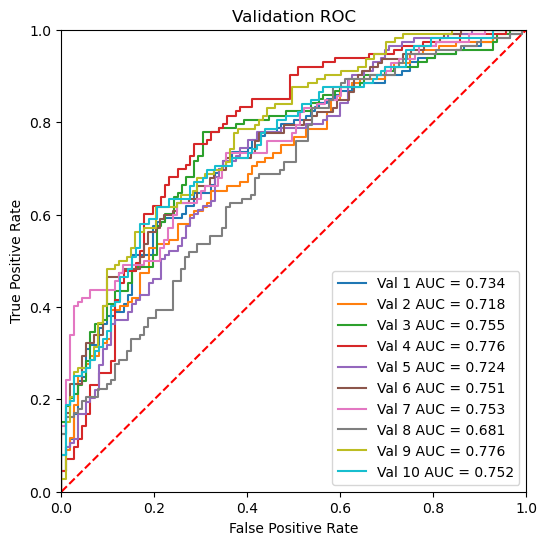

In [132]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_WE_val.png')
plt.show()

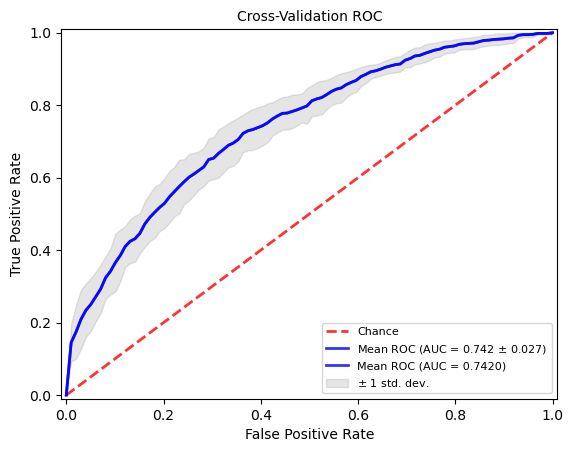

In [133]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_WE_val_mean.png')
plt.show()

In [134]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [135]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [136]:
my_calculate_metrics_list_val

[{'SN': 0.6106194690265486,
  'SP': 0.7321428571428571,
  'ACC': 0.6711111111111111,
  'MCC': 0.34525378207316587,
  'Recall': 0.6106194690265486,
  'Precision': 0.696969696969697,
  'F1-score': 0.6509433962264151,
  'Cutoff': 0.5},
 {'SN': 0.5357142857142857,
  'SP': 0.7946428571428571,
  'ACC': 0.6651785714285714,
  'MCC': 0.3420212749346215,
  'Recall': 0.5357142857142857,
  'Precision': 0.7228915662650602,
  'F1-score': 0.6153846153846154,
  'Cutoff': 0.5},
 {'SN': 0.7964601769911505,
  'SP': 0.6071428571428571,
  'ACC': 0.7022222222222222,
  'MCC': 0.4111777068848026,
  'Recall': 0.7964601769911505,
  'Precision': 0.6716417910447762,
  'F1-score': 0.728744939271255,
  'Cutoff': 0.5},
 {'SN': 0.7256637168141593,
  'SP': 0.7232142857142857,
  'ACC': 0.7244444444444444,
  'MCC': 0.448878002528445,
  'Recall': 0.7256637168141593,
  'Precision': 0.7256637168141593,
  'F1-score': 0.7256637168141593,
  'Cutoff': 0.5},
 {'SN': 0.7610619469026548,
  'SP': 0.5982142857142857,
  'ACC': 0.68,

In [137]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.610619,0.732143,0.671111,0.345254,0.610619,0.696970,0.650943,0.5
1,0.535714,0.794643,0.665179,0.342021,0.535714,0.722892,0.615385,0.5
2,0.796460,0.607143,0.702222,0.411178,0.796460,0.671642,0.728745,0.5
3,0.725664,0.723214,0.724444,0.448878,0.725664,0.725664,0.725664,0.5
4,0.761062,0.598214,0.680000,0.364231,0.761062,0.656489,0.704918,0.5
5,0.714286,0.646018,0.680000,0.361103,0.714286,0.666667,0.689655,0.5
6,0.785714,0.495575,0.640000,0.293814,0.785714,0.606897,0.684825,0.5
7,0.625000,0.619469,0.622222,0.244469,0.625000,0.619469,0.622222,0.5
8,0.741071,0.628319,0.684444,0.371688,0.741071,0.664000,0.700422,0.5
9,0.714286,0.633929,0.674107,0.349344,0.714286,0.661157,0.686695,0.5


In [138]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.610619,0.732143,0.671111,0.345254,0.610619,0.696970,0.650943,0.5
1,0.535714,0.794643,0.665179,0.342021,0.535714,0.722892,0.615385,0.5
2,0.796460,0.607143,0.702222,0.411178,0.796460,0.671642,0.728745,0.5
3,0.725664,0.723214,0.724444,0.448878,0.725664,0.725664,0.725664,0.5
4,0.761062,0.598214,0.680000,0.364231,0.761062,0.656489,0.704918,0.5
5,0.714286,0.646018,0.680000,0.361103,0.714286,0.666667,0.689655,0.5
6,0.785714,0.495575,0.640000,0.293814,0.785714,0.606897,0.684825,0.5
7,0.625000,0.619469,0.622222,0.244469,0.625000,0.619469,0.622222,0.5
8,0.741071,0.628319,0.684444,0.371688,0.741071,0.664000,0.700422,0.5
9,0.714286,0.633929,0.674107,0.349344,0.714286,0.661157,0.686695,0.5


In [139]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\CNN_WE_performance_val.csv',encoding='utf-8')

In [140]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [141]:
roc_auc_list_indep

[0.7680963010204082,
 0.6994579081632654,
 0.7819674744897959,
 0.7566167091836734,
 0.7131696428571429,
 0.7370854591836735,
 0.7673788265306122,
 0.6886957908163266,
 0.7028858418367346,
 0.7113360969387755]

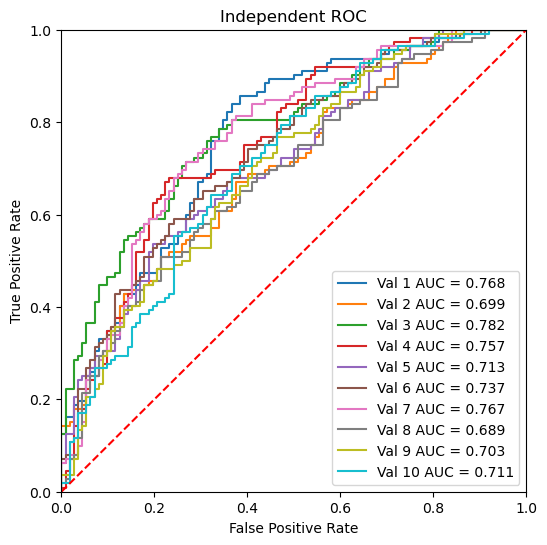

In [142]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_WE_indep.png')
plt.show()

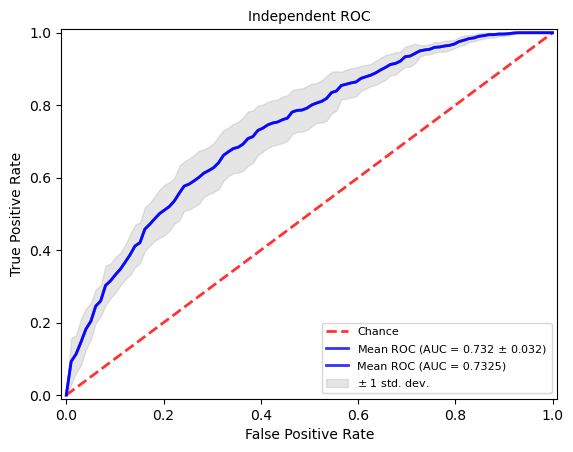

In [143]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_WE_indep_mean.png')
plt.show()

In [144]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [145]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [146]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.678571,0.687500,0.683036,0.366086,0.678571,0.684685,0.681614,0.5
1,0.526786,0.741071,0.633929,0.274227,0.526786,0.670455,0.590000,0.5
2,0.803571,0.607143,0.705357,0.418875,0.803571,0.671642,0.731707,0.5
3,0.678571,0.705357,0.691964,0.384066,0.678571,0.697248,0.687783,0.5
4,0.687500,0.562500,0.625000,0.251976,0.687500,0.611111,0.647059,0.5
5,0.660714,0.669643,0.665179,0.330370,0.660714,0.666667,0.663677,0.5
6,0.812500,0.598214,0.705357,0.420482,0.812500,0.669118,0.733871,0.5
7,0.589286,0.678571,0.633929,0.268931,0.589286,0.647059,0.616822,0.5
8,0.705357,0.580357,0.642857,0.287973,0.705357,0.626984,0.663866,0.5
9,0.651786,0.633929,0.642857,0.285760,0.651786,0.640351,0.646018,0.5


In [147]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.678571,0.687500,0.683036,0.366086,0.678571,0.684685,0.681614,0.5
1,0.526786,0.741071,0.633929,0.274227,0.526786,0.670455,0.590000,0.5
2,0.803571,0.607143,0.705357,0.418875,0.803571,0.671642,0.731707,0.5
3,0.678571,0.705357,0.691964,0.384066,0.678571,0.697248,0.687783,0.5
4,0.687500,0.562500,0.625000,0.251976,0.687500,0.611111,0.647059,0.5
5,0.660714,0.669643,0.665179,0.330370,0.660714,0.666667,0.663677,0.5
6,0.812500,0.598214,0.705357,0.420482,0.812500,0.669118,0.733871,0.5
7,0.589286,0.678571,0.633929,0.268931,0.589286,0.647059,0.616822,0.5
8,0.705357,0.580357,0.642857,0.287973,0.705357,0.626984,0.663866,0.5
9,0.651786,0.633929,0.642857,0.285760,0.651786,0.640351,0.646018,0.5


In [148]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\CNN_WE\result\CNN_WE_performance_indep.csv',encoding='utf-8')

In [149]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

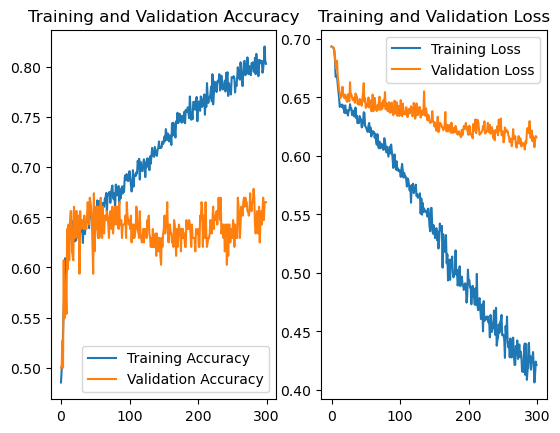

In [150]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()